In [1]:
import time
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
torch.set_default_dtype(torch.float64)

import DRLPDE_nn
import DRLPDE_functions.EvaluateWalkers
import DRLPDE_param_solver
 
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import matplotlib as mpl




In [2]:
mu = 1

# Physical Dimension
x_dim = 2
output_dim = 2

# Neural Network Architecture
nn_depth = 60
nn_width = 4

periodic1 = { 'variable':'x', 
              'base':-math.pi,
              'top':math.pi }

periodic2 = { 'variable':'y', 
              'base':-math.pi,
              'top':math.pi }

list_of_periodic_boundaries =[periodic1, periodic2]

class bdry_periodic:

    def __init__(self, variable, base, top):
        
        if variable == 'x':
            self.index = 0
        if variable == 'y':
            self.index = 1
        if variable == 'z':
            self.index = 2

        self.base = base
        self.top = top

my_periodic_boundaries = []
for specs in list_of_periodic_boundaries:
    my_periodic_boundaries.append( bdry_periodic( variable = specs['variable'],
                                                    base = specs['base'],
                                                    top = specs['top']  ))


In [3]:
nn_param = {'depth': nn_depth,
            'width': nn_width,
            'x_dim': x_dim,
            'is_unsteady': True ,
            'output_dim': output_dim
            }

vel_nn_param = {'depth': 60,
            'width': 4,
            'x_dim': 2,
            'is_unsteady': True ,
            'output_dim': 2
            }

In [4]:
class FeedForwardNN(nn.Module):
    
    ### Feed forward neural network
    
    def __init__(self, depth, width, x_dim, is_unsteady, output_dim, **nn_param):
        super(FeedForwardNN, self).__init__()
        
        self.input_dim = x_dim + is_unsteady
        
        modules = []
        modules.append(nn.Linear(self.input_dim, depth))
        for i in range(width - 1):
            modules.append(nn.Linear(depth, depth))
            modules.append(nn.ELU())
        modules.append(nn.Linear(depth, 1))
        
        self.sequential_model = nn.Sequential(*modules)
        
    def forward(self, x):
        a = self.sequential_model(x)
        
        return a


def eval_gradient(X, model):
    X.requires_grad = True
    a = model(X)

    grad_model = torch.autograd.grad(a, X, grad_outputs = torch.ones_like(a), create_graph = True, 
                                       retain_graph = True, only_inputs = True)[0]

    return grad_model[:,:x_dim]

In [5]:
def true_pressure(x):
    p = -1/4 * (torch.cos(2*x[:,0]) + torch.cos(2*x[:,1]))*torch.exp(-4*mu*x[:,2])
    return p

def shifted_pressure(x):
    ### zero at point (0,0)

    x0 = torch.cat( ( torch.zeros_like(x[:,:-1]), x[:,-1,None] ), dim=1)

    p = true_pressure(x) - true_pressure(x0)

    return p

def true_solution(X):
    u = torch.stack( ( torch.cos(X[:,0])*torch.sin(X[:,1])*torch.exp(-2*mu*X[:,2]),
                       -torch.sin(X[:,0])*torch.cos(X[:,1])*torch.exp(-2*mu*X[:,2]) ), dim=1)
    return u

def true_pressure_gradient(x):

    p1 = 1/2 * (torch.sin(2*x[:,0]))*torch.exp(-4*mu*x[:,2])
    p2 = 1/2 * (torch.sin(2*x[:,1]))*torch.exp(-4*mu*x[:,2])

    return torch.stack((p1,p2), dim=1)


In [6]:
model_velocity = DRLPDE_nn.IncompressibleNN(**vel_nn_param)
model_velocity.load_state_dict(torch.load("savedmodels/TaylorGreen.pt"))
model_velocity.to('cpu').eval()

model_pressure = FeedForwardNN(**nn_param)
model_pressure.load_state_dict(torch.load("savedmodels/pressureTaylorGreen.pt"))
model_pressure.to('cpu').eval()

FeedForwardNN(
  (sequential_model): Sequential(
    (0): Linear(in_features=3, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=60, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ELU(alpha=1.0)
    (5): Linear(in_features=60, out_features=60, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [7]:

dt = 1e-1
num_ghost = 512
tol = 1e-6

def periodic_condition(Xnew, periodic_boundaries):
    for bdry in periodic_boundaries:
        below_base = Xnew[:,bdry.index] < bdry.base
        above_top = Xnew[:,bdry.index] > bdry.top

        if torch.sum(below_base) > 0:
            Xnew[below_base, bdry.index] = Xnew[below_base, bdry.index] + (bdry.top - bdry.base)
        if torch.sum(above_top) > 0:
            Xnew[above_top,bdry.index] = Xnew[above_top, bdry.index] - (bdry.top - bdry.base)
    return Xnew

def find_time_exit(Xold, Xnew, tol):
    ### Bisection algorithm to find the time exit up to a tolerance
    
    Xmid = (Xnew + Xold)/2

    # above tolerance = inside
    # below tolerance = outside
    above_tol = Xmid[:,-1] > tol
    below_tol = Xmid[:,-1] < -tol

    if torch.sum(above_tol + below_tol) > 0:
        Xnew[below_tol,:] = Xmid[below_tol,:]
        Xold[above_tol,:] = Xmid[above_tol,:]
        
        Xmid[above_tol + below_tol,:] = find_time_exit(Xold[above_tol + below_tol,:], Xnew[above_tol + below_tol,:], tol)

    return Xmid
    

def make_target(Xold):

    numpts = Xold.size(0)

    ### Generate points -- requires grad

    ### Move Walkers
    #Uold = model_velocity(Xold)
    Uold = true_solution(Xold)

    Zt = np.sqrt(dt)*torch.randn((numpts*num_ghost, x_dim))

    Xnew = Xold.detach().repeat(num_ghost,1)  + torch.cat( (-dt*Uold.detach().repeat(num_ghost,1) + np.sqrt(2*mu)*Zt, 
                                                            -dt*torch.ones((numpts*num_ghost,1))), dim=1)


    ### Initial condition
    #hit_initial = Xnew[:,-1] < 0
    #Xnew[hit_initial,:] = find_time_exit(Xold.repeat(num_ghost,1)[hit_initial,:], Xnew[hit_initial,:], tol)

    ### Calculate periodic boundaries
    Xnew = periodic_condition(Xnew, my_periodic_boundaries)

    #Xnew.requires_grad=True
    #Unew = model_velocity(Xnew).reshape(num_ghost, numpts, output_dim).mean(0)
    Unew = true_solution(Xnew).reshape(num_ghost, numpts, output_dim).mean(0)

    ###
    target = (Unew - Uold).detach()/dt

    return target


(-0.5, 0.5)

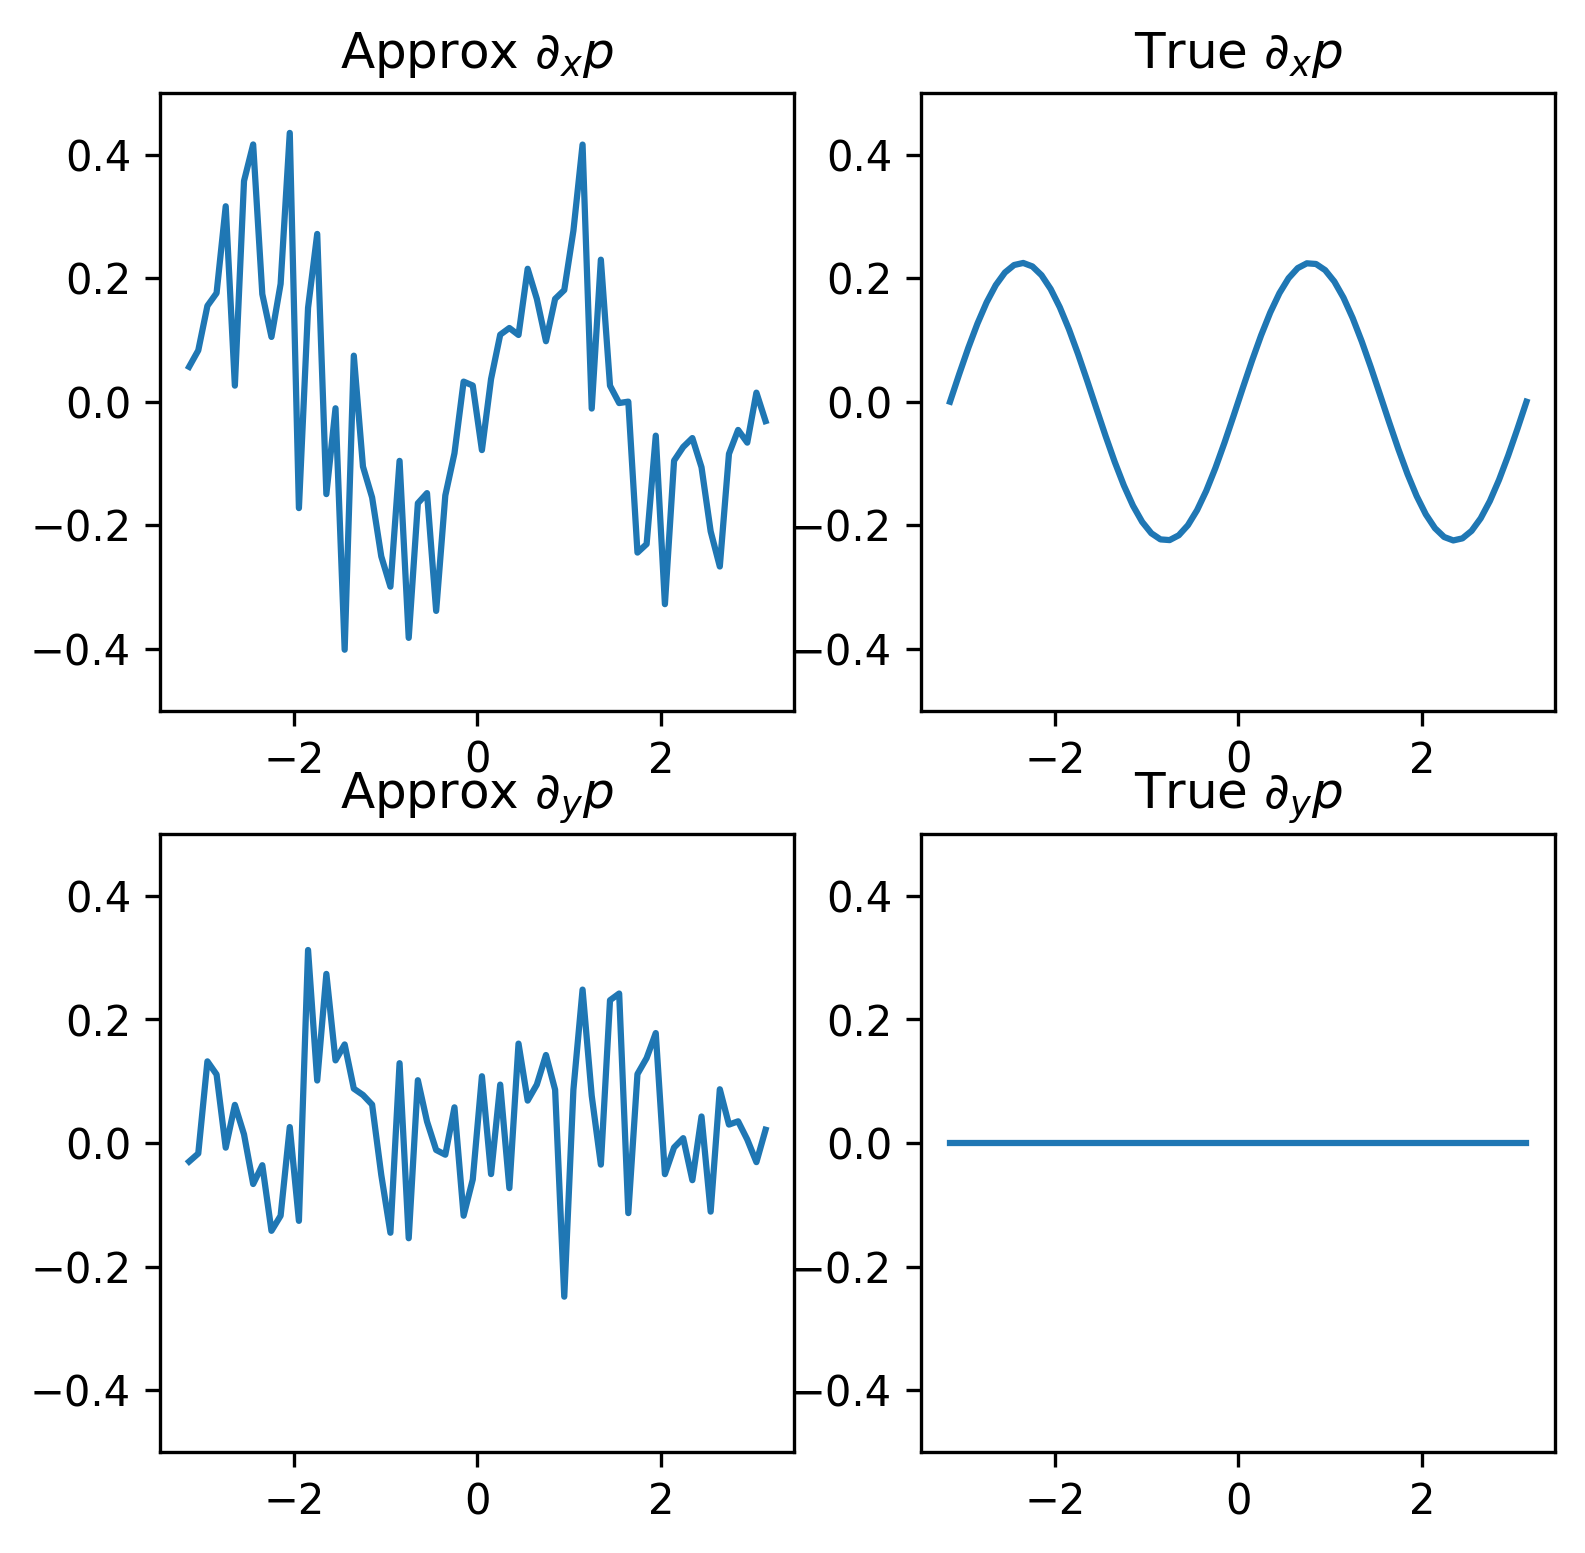

In [8]:
xtest = torch.empty((64,3))
xtest[:,0] = torch.linspace(-math.pi, math.pi, 64)
xtest[:,1] = math.pi/2
xtest[:,2] = 0.2

pgrad_test = make_target(xtest.requires_grad_(True))
pgrad_true = true_pressure_gradient(xtest)

plt.close('all')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[6, 6])

ax[0,0].plot(np.linspace(-math.pi, math.pi, 64), pgrad_test[:,0].detach().numpy())
ax[0,0].set_title(r'Approx $\partial_x p$')
ax[0,0].set_ylim([-0.5,0.5])

ax[0,1].plot(np.linspace(-math.pi, math.pi, 64), pgrad_true[:,0].detach().numpy())
ax[0,1].set_title(r'True $\partial_x p$')
ax[0,1].set_ylim([-0.5,0.5])

ax[1,0].plot(np.linspace(-math.pi, math.pi, 64), pgrad_test[:,1].detach().numpy())
ax[1,0].set_title(r'Approx $\partial_y p$')
ax[1,0].set_ylim([-0.5,0.5])

ax[1,1].plot(np.linspace(-math.pi, math.pi, 64), pgrad_true[:,1].detach().numpy())
ax[1,1].set_title(r'True $\partial_y p$')
ax[1,1].set_ylim([-0.5,0.5])


In [9]:
####################### Plotting and Error Parameters ########################
numpts_x = 64
numpts_y =  64

numpts_time = 50

xg = torch.cat( (torch.cartesian_prod(torch.linspace(-math.pi,math.pi,numpts_x),
                                         torch.linspace(-math.pi,math.pi,numpts_y)), 
                    torch.zeros((numpts_x*numpts_y,1))), dim=1).requires_grad_(True)

#x1g, x2g = torch.meshgrid( (torch.linspace(-math.pi,math.pi,numpts_x),torch.linspace(-math.pi,math.pi,numpts_y)))
#xg = torch.stack( (x1g.reshape(-1), x2g.reshape(-1), torch.zeros((numpts_x*numpts_y))), dim=1).requires_grad_(True)

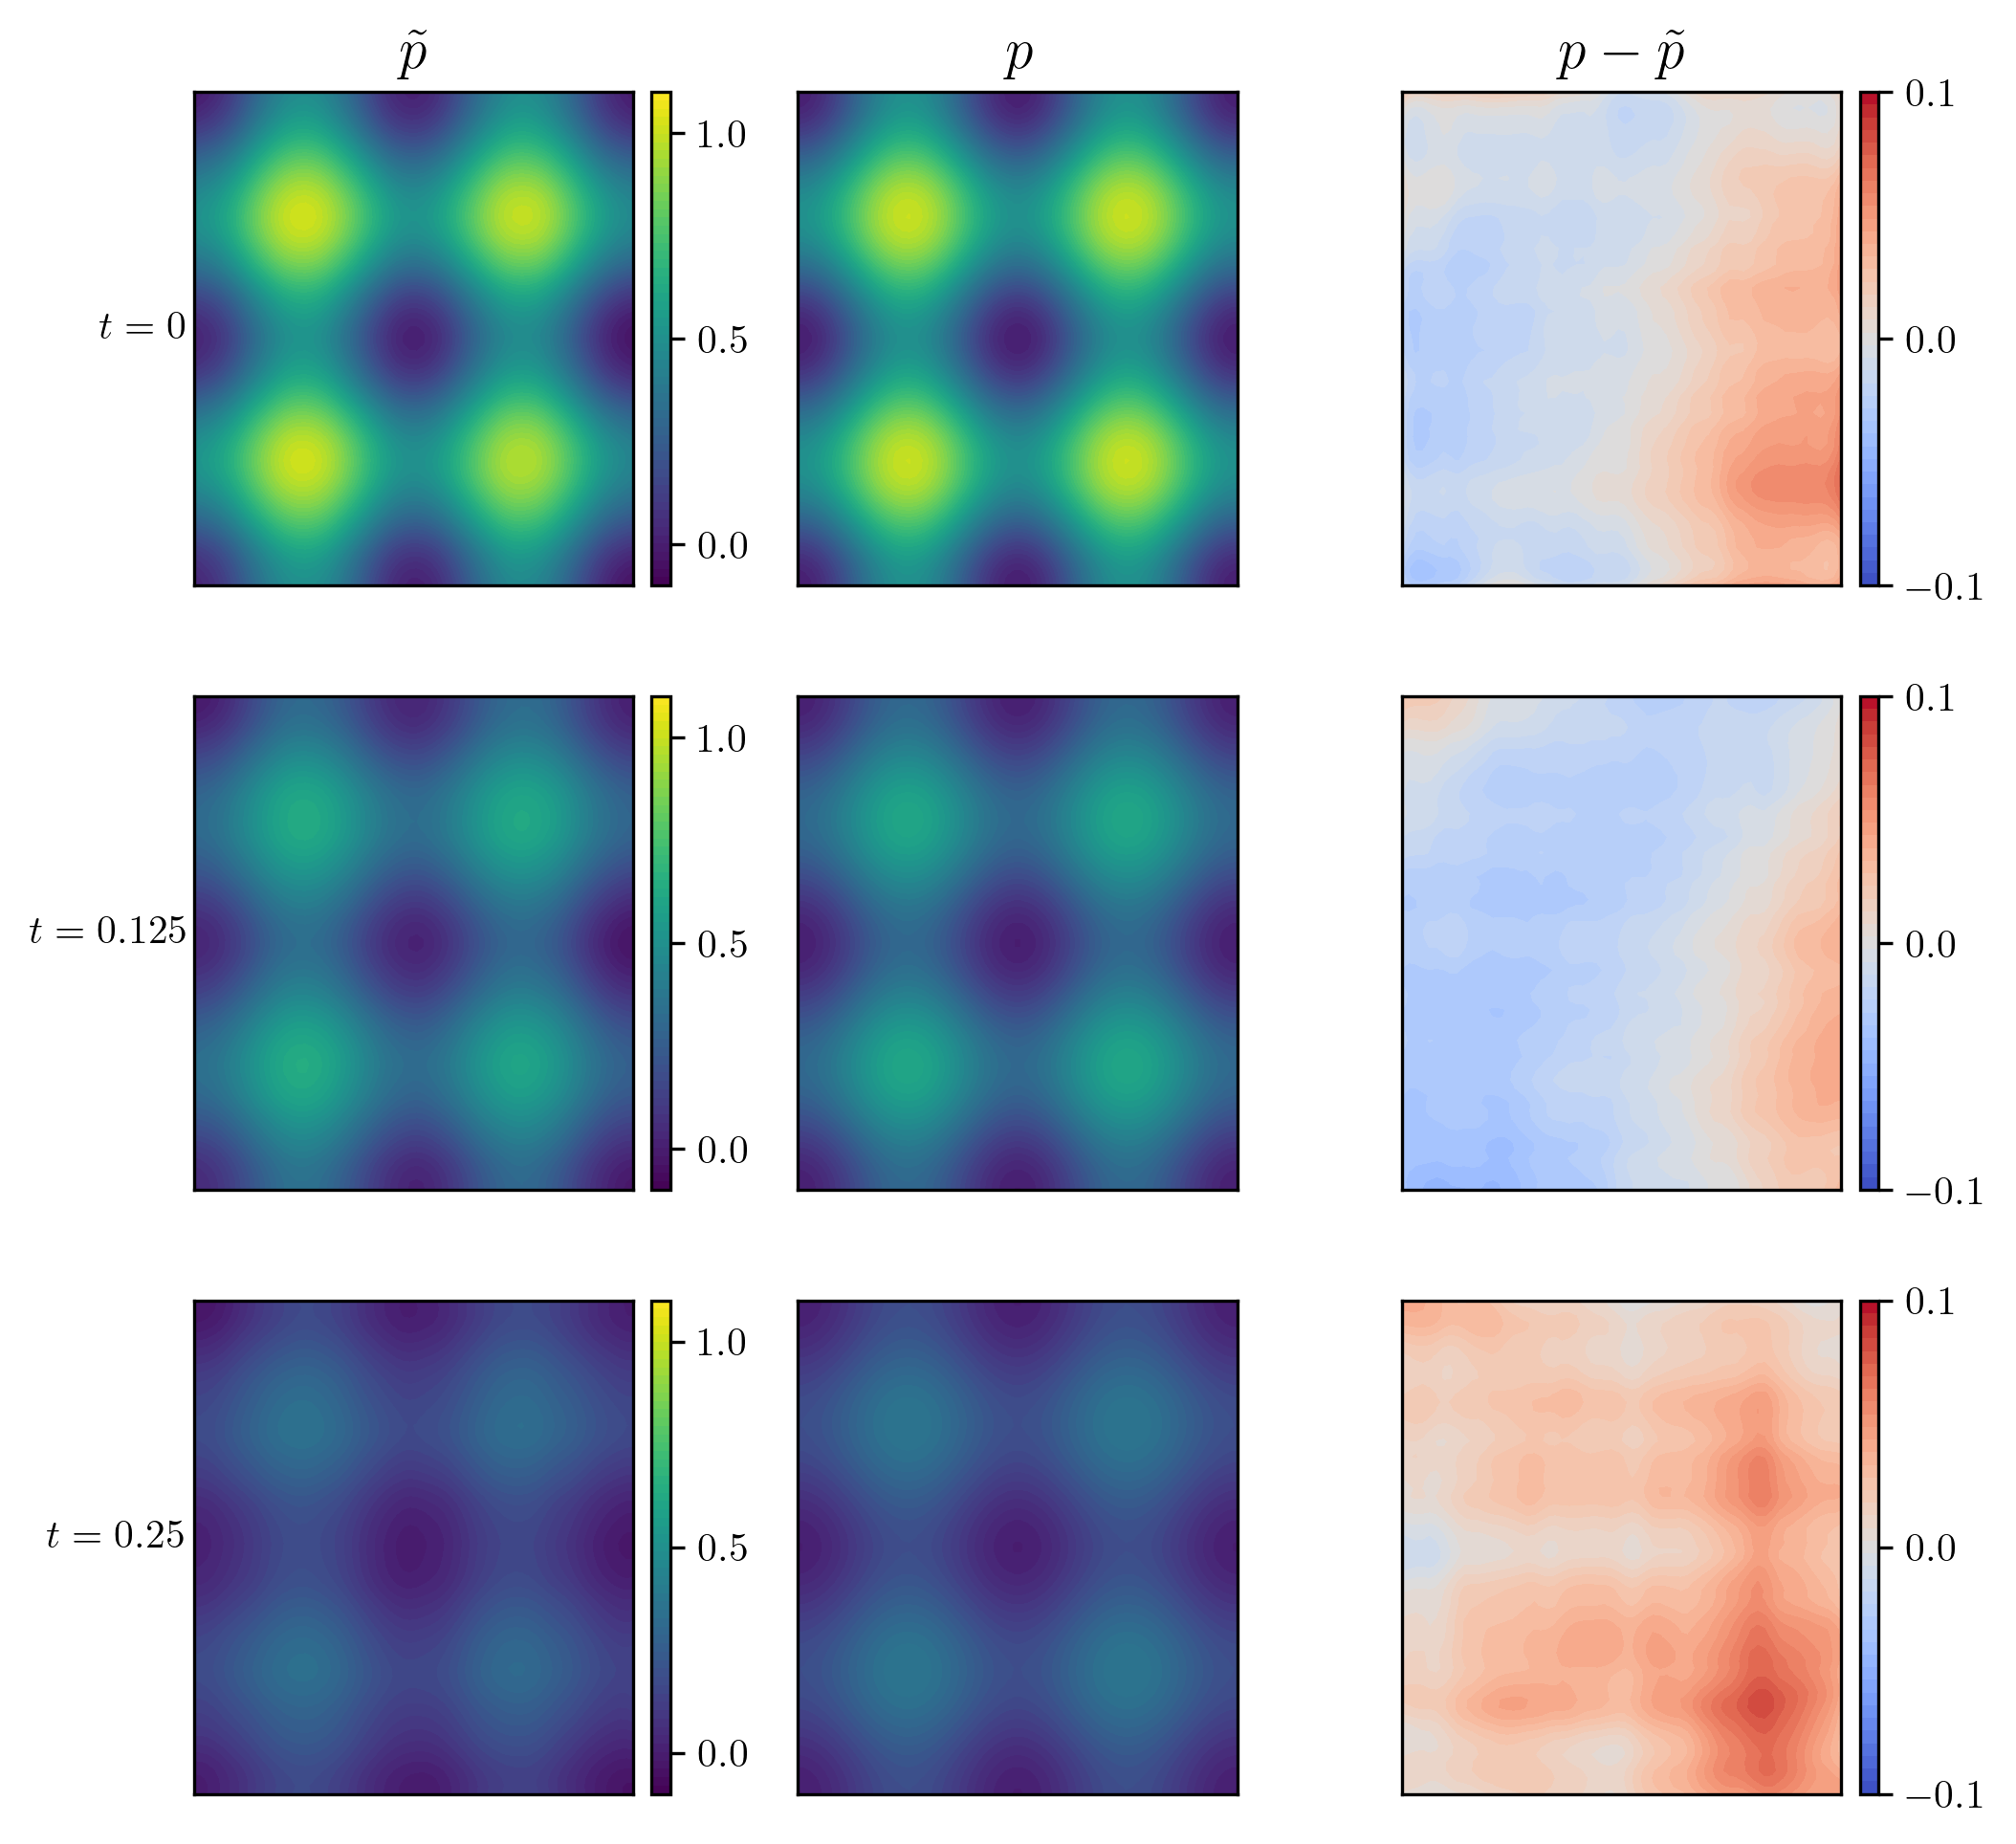

In [27]:
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[6.4, 6.4])

plt.tight_layout(pad=0.5)

xplot = xg[:,0].reshape(numpts_x, numpts_y).detach().numpy()
yplot = xg[:,1].reshape(numpts_x, numpts_y).detach().numpy()

levels_p = np.linspace(-0.1, 1.1, 60)
ticks_p = [0, 0.5, 1.0]

levels_error = np.linspace(-0.1, 0.1, 40)
ticks_error = [-0.1, 0, 0.1]

### Different Times

# t = 0.0

xg.requires_grad=False
xg[:,2] = 0.0
xg.requires_grad=True

Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

True_P = shifted_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

#target = make_target(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()

contour0 = ax[0,0].contourf(xplot, yplot, Trained_P, levels_p , cmap=plt.cm.viridis)
ax[0,0].set_title(r'$\tilde{p}$')
ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)
colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.01,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])

colorbar0 = plt.colorbar(contour0, ticks=ticks_p, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)

ax[0,0].text(-4.5,
             0,
             r'$t=0$',
             fontsize=10)

contour1 = ax[0,1].contourf(xplot, yplot, True_P, levels_p , cmap=plt.cm.viridis)
ax[0,1].set_title(r'$p$')
ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour2 = ax[0,2].contourf(xplot, yplot, True_P - Trained_P, levels_error, cmap=plt.cm.coolwarm)
ax[0,2].set_title(r'$p - \tilde{p}$')

ax[0,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar2_param = fig.add_axes(
    [ax[0,2].get_position().x1 + 0.01,
     ax[0,2].get_position().y0,
     0.01,
     ax[0,2].get_position().height])
colorbar2 = plt.colorbar(contour2, ticks=ticks_error, cax = colorbar2_param)
colorbar2.ax.tick_params(labelsize=10)

#contour21 = ax[0,3].contourf(xplot, yplot, target[:,:,0], cmap=plt.cm.coolwarm)
#ax[0,3].set_title(r'Target')
#ax[0,3].set_xticklabels([])
#ax[0,3].set_yticklabels([])
#plt.colorbar(contour21, ax=ax[0,3])

# t = 0.125

xg.requires_grad=False
xg[:,2] = 0.125
xg.requires_grad=True

Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

True_P = shifted_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

#target = make_target(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()

contour3 = ax[1,0].contourf(xplot, yplot, Trained_P, levels_p, cmap=plt.cm.viridis)

ax[1,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)
colorbar3_param = fig.add_axes(
    [ax[1,0].get_position().x1 + 0.01,
     ax[1,0].get_position().y0,
     0.01,
     ax[1,0].get_position().height])
colorbar3 = plt.colorbar(contour3, ticks=ticks_p, cax = colorbar3_param)
colorbar3.ax.tick_params(labelsize=10)

ax[1,0].text(-5.5,
             0,
             r'$t=0.125$',
             fontsize=10)

contour4 = ax[1,1].contourf(xplot, yplot, True_P, levels_p, cmap=plt.cm.viridis)

ax[1,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)


contour5 = ax[1,2].contourf(xplot, yplot, True_P - Trained_P, levels_error, cmap=plt.cm.coolwarm)

ax[1,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar5_param = fig.add_axes(
    [ax[1,2].get_position().x1 + 0.01,
     ax[1,2].get_position().y0,
     0.01,
     ax[1,2].get_position().height])
colorbar5 = plt.colorbar(contour5, ticks=ticks_error, cax = colorbar5_param)
colorbar5.ax.tick_params(labelsize=10)


#contour51 = ax[1,3].contourf(xplot, yplot, target[:,:,0], cmap=plt.cm.coolwarm)
#ax[1,3].set_title(r'Target')
#ax[1,3].set_xticklabels([])
#ax[1,3].set_yticklabels([])
#plt.colorbar(contour51, ax=ax[1,3])

# t = 0.25

xg.requires_grad=False
xg[:,2] = 0.25
xg.requires_grad=True

Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

True_P = shifted_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

#target = make_target(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()

contour6 = ax[2,0].contourf(xplot, yplot, Trained_P, levels_p, cmap=plt.cm.viridis)

ax[2,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar6_param = fig.add_axes(
    [ax[2,0].get_position().x1 + 0.01,
     ax[2,0].get_position().y0,
     0.01,
     ax[2,0].get_position().height])
colorbar6 = plt.colorbar(contour6, ticks=ticks_p, cax = colorbar6_param)
colorbar6.ax.tick_params(labelsize=10)

ax[2,0].text(-5.25,
             0,
             r'$t=0.25$',
             fontsize=10)

contour7 = ax[2,1].contourf(xplot, yplot, True_P, levels_p, cmap=plt.cm.viridis)
ax[2,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)


contour8 = ax[2,2].contourf(xplot, yplot, True_P - Trained_P, levels_error, cmap=plt.cm.coolwarm)
ax[2,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar8_param = fig.add_axes(
    [ax[2,2].get_position().x1 + 0.01,
     ax[2,2].get_position().y0,
     0.01,
     ax[2,2].get_position().height])
colorbar8 = plt.colorbar(contour8, ticks=ticks_error, cax = colorbar8_param)
colorbar8.ax.tick_params(labelsize=10)


#contour81 = ax[2,3].contourf(xplot, yplot, target[:,:,0], cmap=plt.cm.coolwarm)
#ax[2,3].set_title(r'Target')
#ax[2,3].set_xticklabels([])
#ax[2,3].set_yticklabels([])
#plt.colorbar(contour81, ax=ax[2,3])

In [30]:
### Error Calculation

dt = 0.25/numpts_time

xg = torch.cat( ( torch.cartesian_prod( torch.linspace(-math.pi,math.pi,numpts_x),
                                              torch.linspace(-math.pi,math.pi,numpts_y)),
                   torch.zeros((numpts_x*numpts_y,1))), dim=1).requires_grad_(False)

integral_factor =  (4*math.pi**2)/(numpts_x - 1)/(numpts_y-1)

L2_error = np.empty((numpts_time))
Linf_error = np.empty((numpts_time))
L2_norm_true = np.empty((numpts_time))
Linf_norm_true = np.empty(numpts_time)
at_origin = np.empty((numpts_time))

for tt in range(numpts_time):
    #xg.requires_grad=False
    xg[:,2] = tt*dt
    #xg.requires_grad=True

    Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

    True_P = shifted_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

    L2_error[tt] = np.sum( (Trained_P - True_P)**2 )*integral_factor

    Linf_error[tt] = np.max(np.abs(Trained_P - True_P))

    L2_norm_true[tt] = np.sum( True_P**2)*integral_factor

    Linf_norm_true[tt] = np.max(np.abs(True_P))

    x0 = torch.tensor([[0,0,tt*dt]])
    at_origin[tt] = model_pressure(x0).detach().numpy()

L2_error_full = np.sqrt(np.sum(L2_error)*dt)
L2_norm_true_full = np.sqrt(np.sum( L2_norm_true)*dt)
Linf_error_full = np.amax(Linf_error)

print('L2 error = {:.4f}'.format(L2_error_full))
print('Linf error = {:.4f}'.format(Linf_error_full))
print('L2 Relative error = {:.4f}'.format(L2_error_full/L2_norm_true_full))
print('L2 norm true = {:.4f}'.format(L2_norm_true_full))
print('Error at origin = {:.4f}'.format(np.amax(np.abs(at_origin))))


L2 error = 0.0692
Linf error = 0.0796
L2 Relative error = 0.0590
L2 norm true = 1.1718
Error at origin = 0.0174


In [31]:
xg[:,2] = 0.25
Trained_P = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

True_P = shifted_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

np.amax(np.abs(Trained_P - True_P))/

0.08271873923793821

Text(0.5, 1.0, 'Error at origin at each time')

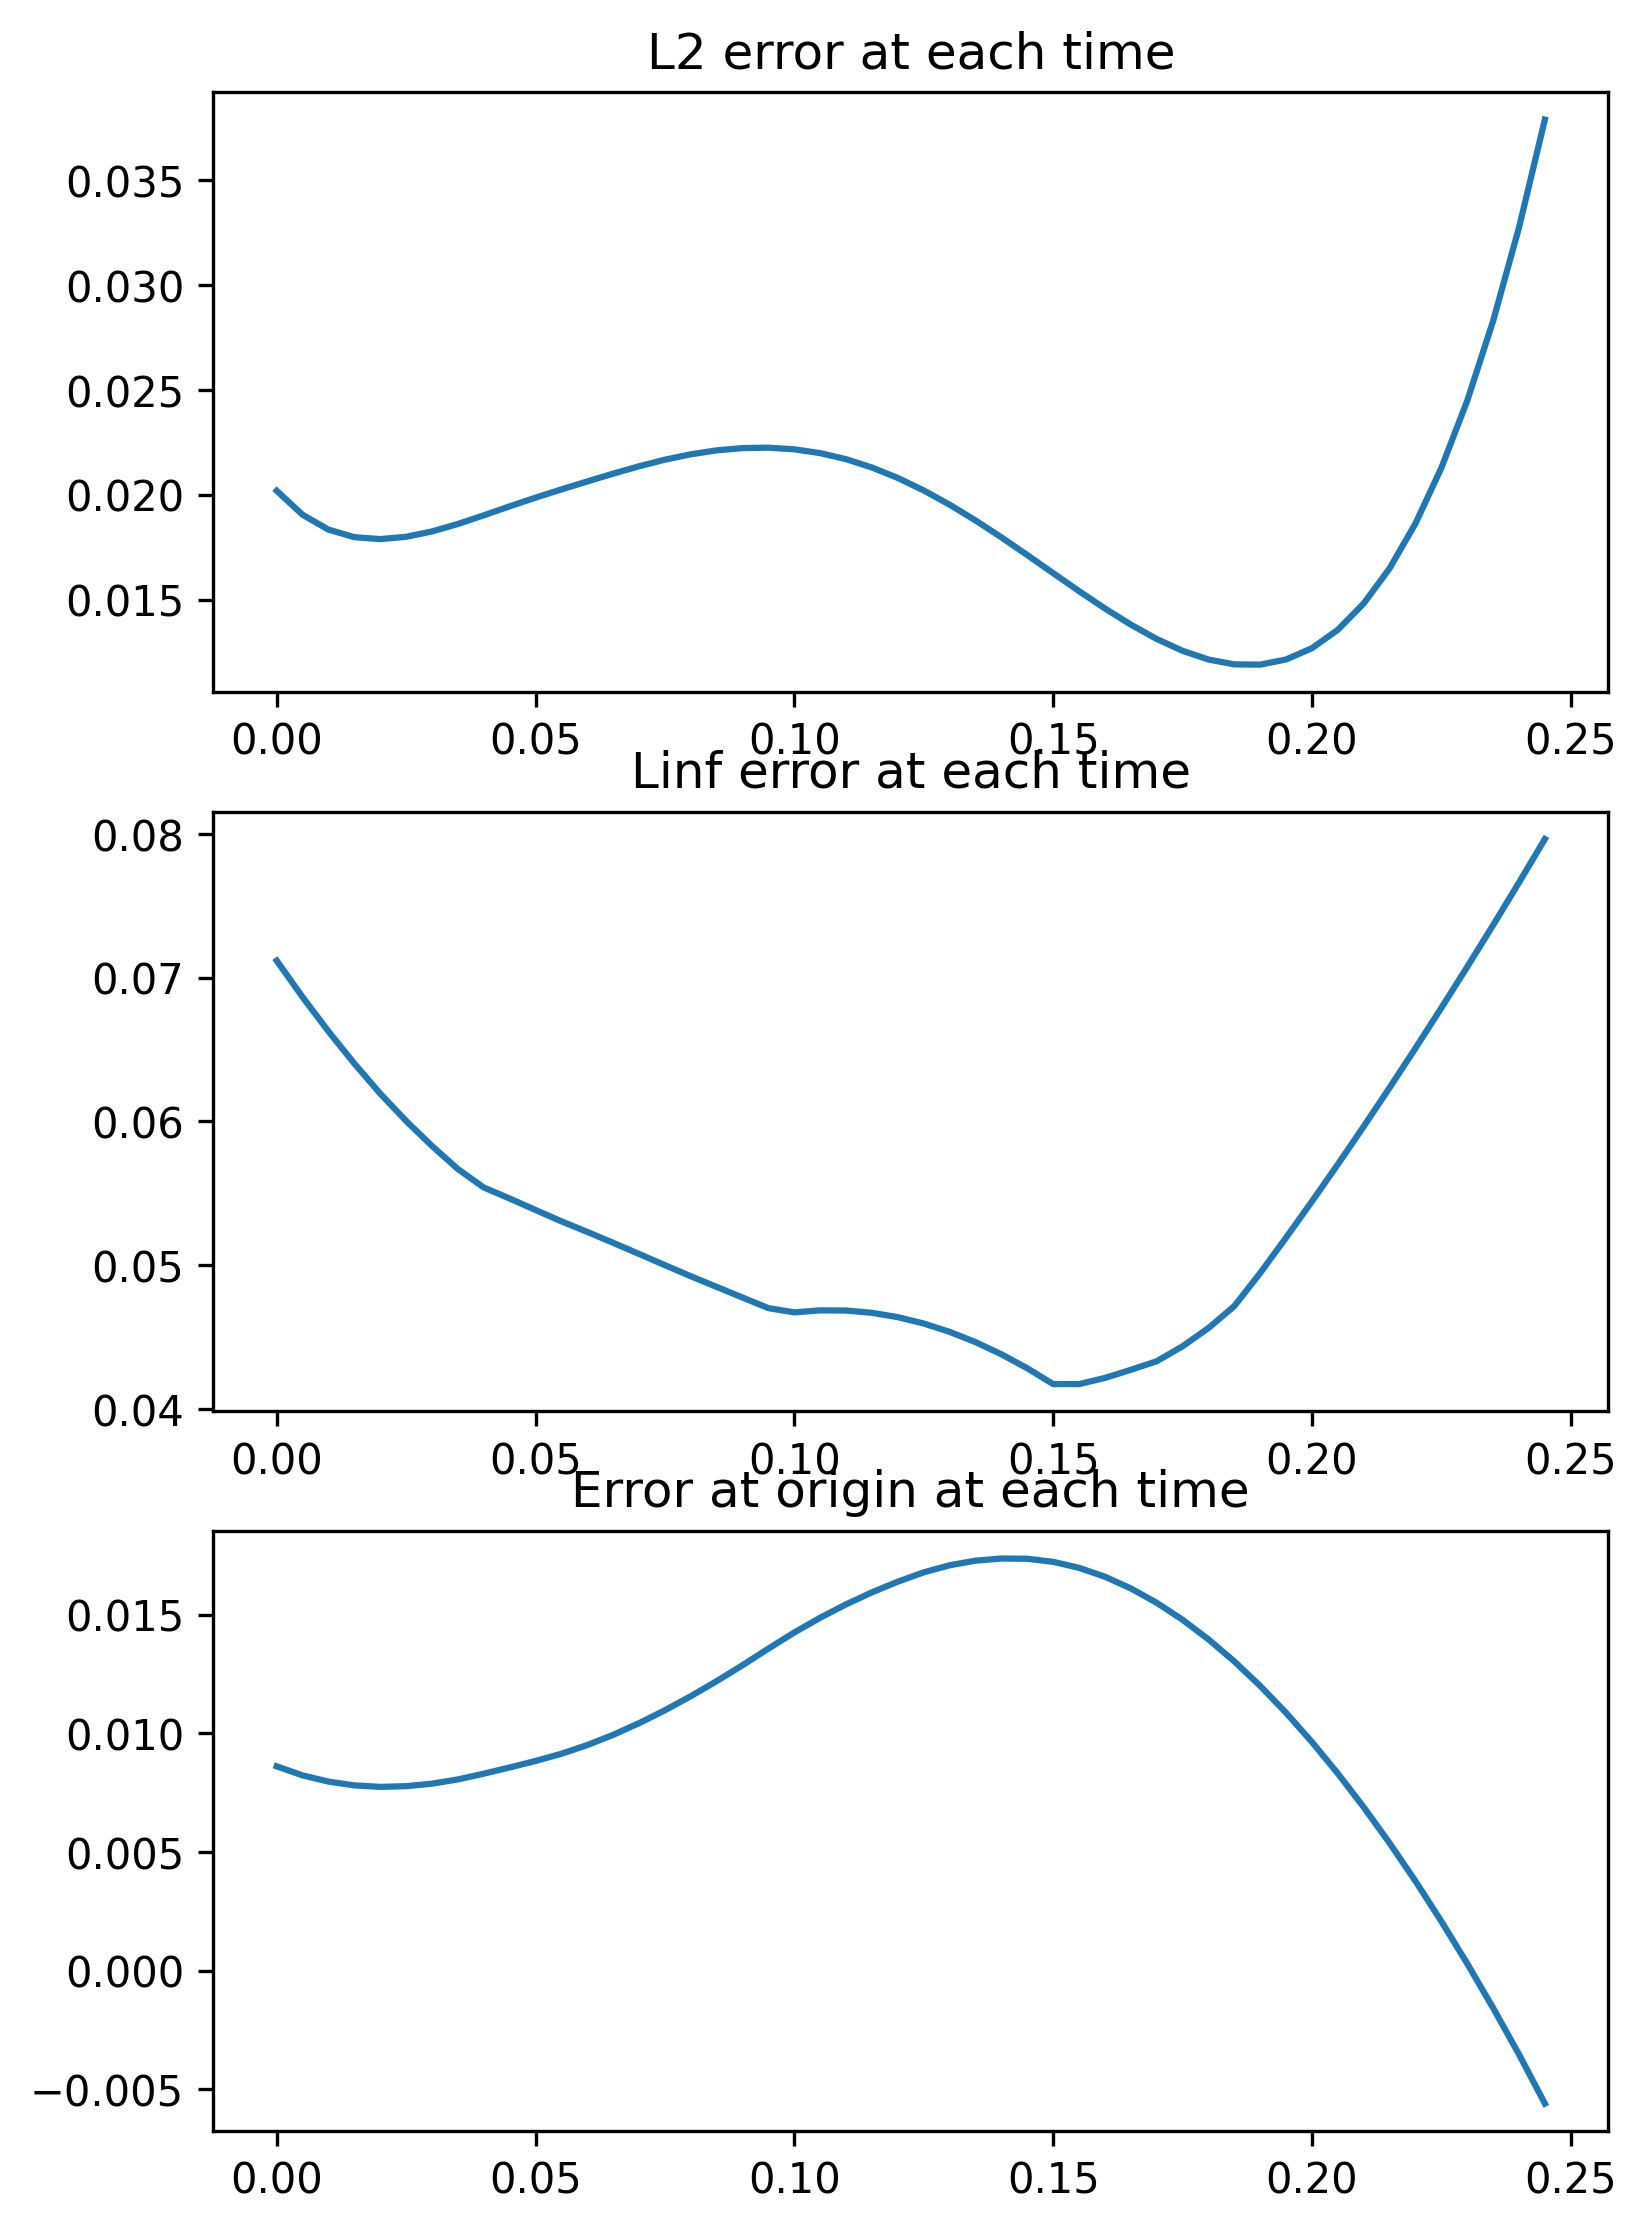

In [12]:
plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[6, 9])

ax[0].plot( np.arange(numpts_time)*dt, L2_error)
ax[0].set_title('L2 error at each time')

ax[1].plot( np.arange(numpts_time)*dt, Linf_error)
ax[1].set_title('Linf error at each time')

ax[2].plot( np.arange(numpts_time)*dt, at_origin)
ax[2].set_title('Error at origin at each time')

In [13]:
import pickle

with open('Pressure_Errors.pickle', 'rb') as f:
    Errors = pickle.load(f)

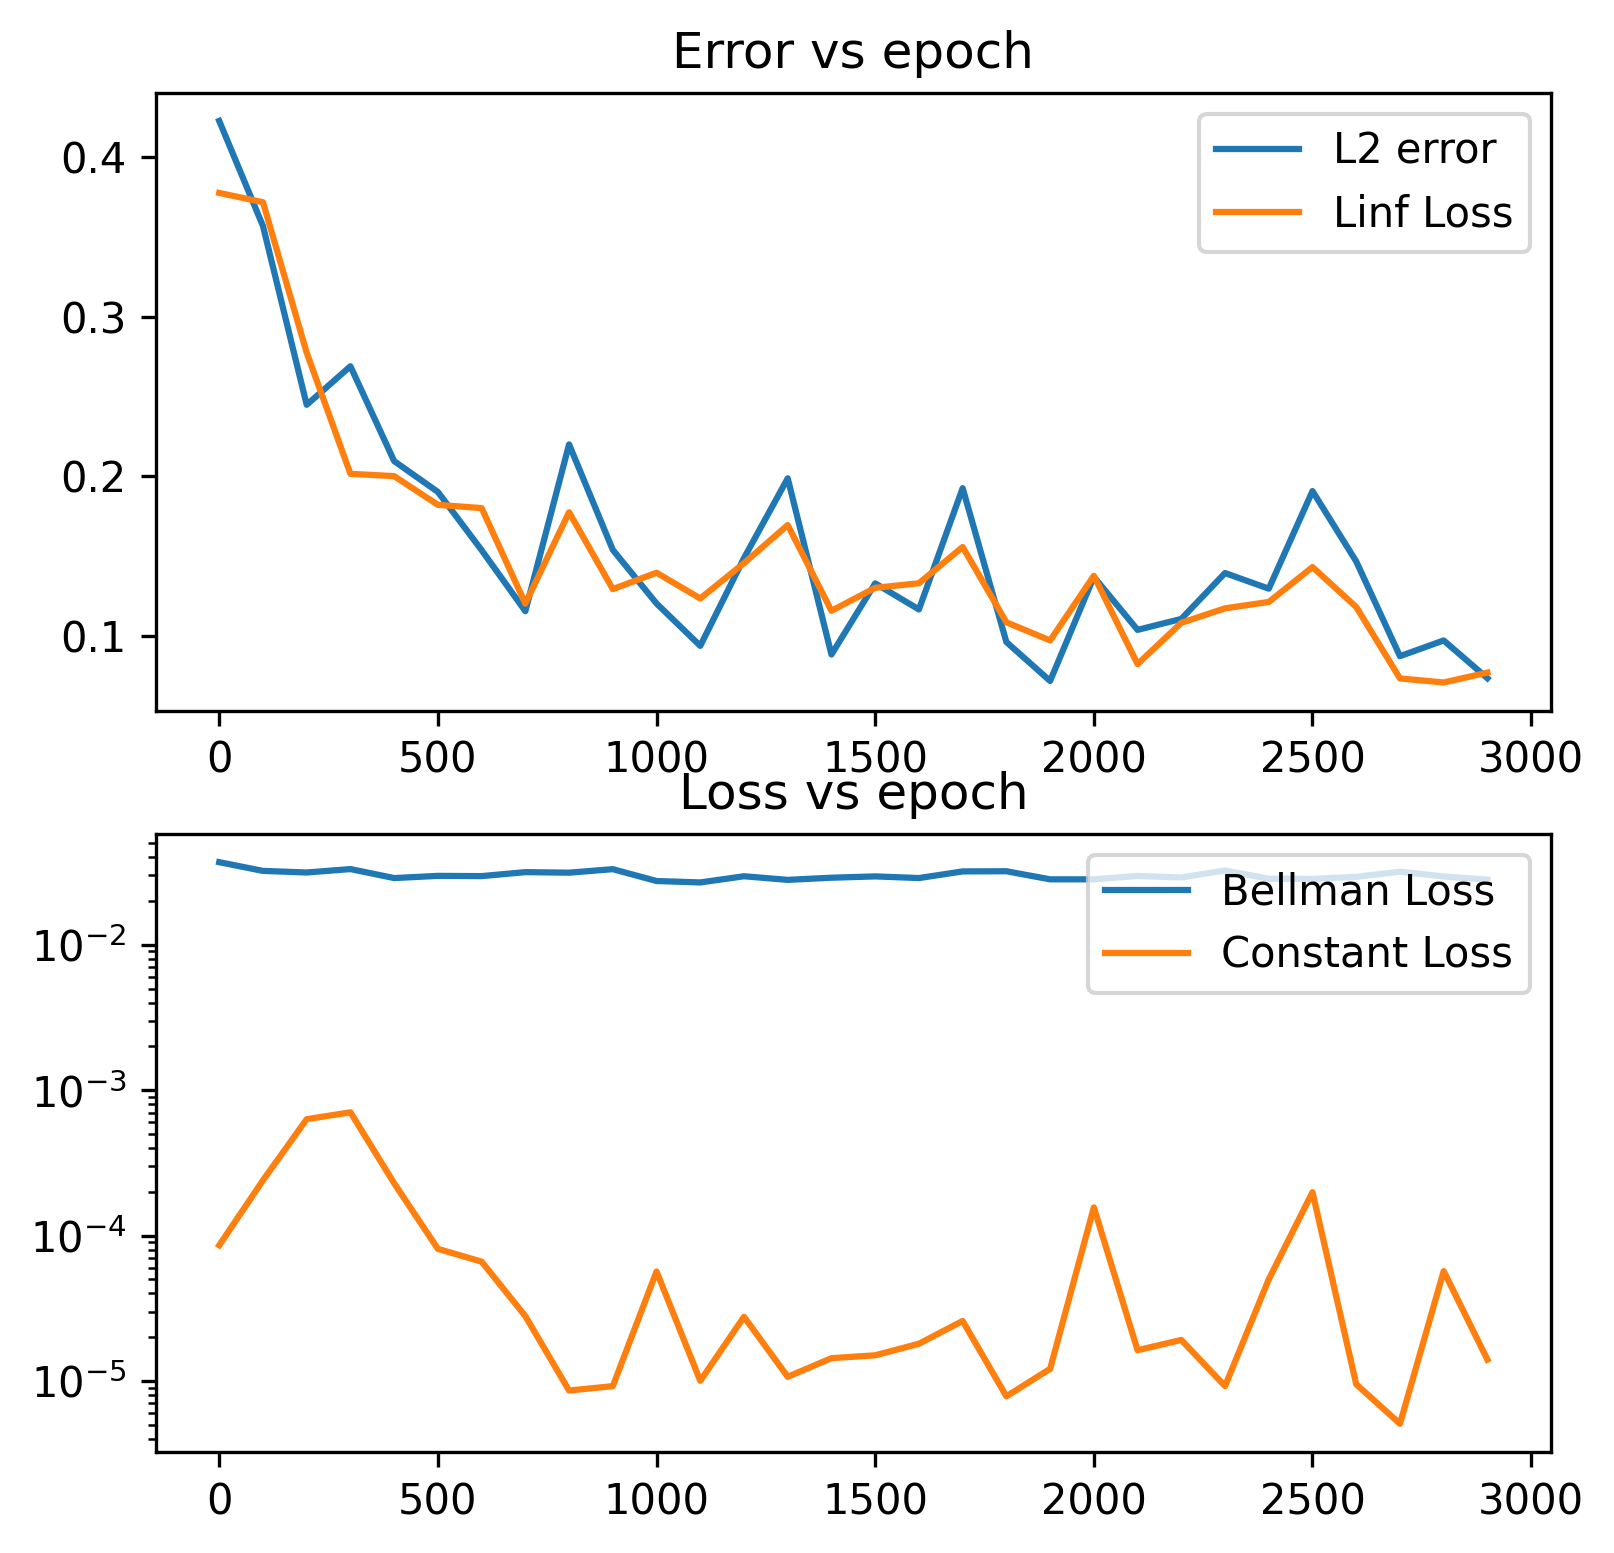

In [14]:
calc_error_every = 100

plt.close('all')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[6, 6])

ax[0].plot( np.arange(Errors[:,0].size)*calc_error_every, Errors[:,0], label='L2 error')
ax[0].plot( np.arange(Errors[:,1].size)*calc_error_every, Errors[:,1], label='Linf Loss')

ax[0].set_title('Error vs epoch')
ax[0].legend(loc='upper right')

ax[1].set_yscale('log')
ax[1].plot( np.arange(Errors[:,2].size)*calc_error_every, Errors[:,2], label='Bellman Loss')
ax[1].plot( np.arange(Errors[:,3].size)*calc_error_every, Errors[:,3], label='Constant Loss')

ax[1].set_title('Loss vs epoch')
ax[1].legend(loc='upper right')
